## Classificação de Leucemias com K-NN e Seleção de Genes
**Dupla**: Beatriz Evelyn Dalfior (22.1.8012), Amanda Jacomette Dias Barbosa (22.1.8025)

**Disciplina**: Aprendizagem de Máquina (CSI704)

**Professor**: Luiz Carlos Bambirra Torres

---

In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SequentialFeatureSelector
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate



___

### 1.1 Aquisição e inspeção 
#### Informações sobre o dataset
O dataset Gene expression dataset (Golub et al.) contém perfis de expressão de 7.129 genes medidos em 72 amostras de leucemia – 47 ALL (linfoblástica) e 25 AML (mieloblástica).

#### Arquivos
- **Treino**: `data_set_ALL_AML_train.csv`
- **Teste**: `data_set_ALL_AML_independent.csv`
- **Rótulos**: `actual.csv`

In [93]:
# ------------------------- Load dataset -------------------------

df_train = pd.read_csv('data_set_ALL_AML_train.csv', encoding='latin1')
df_test = pd.read_csv('data_set_ALL_AML_independent.csv', encoding='latin1')
df_labels = pd.read_csv('actual.csv', encoding='latin1')


___

### 1.2 Pré-processamento
Algumas observações sobre os dados precisam ser feitas:
- Os arquivos de *treino* e *teste* têm **genes** nas linhas e **amostras** nas colunas: é preciso **transpor** os arquivos para que cada linha represente uma amostra e cada coluna um gene;
- As colunas **call** são valores qualitativos, indicando a qualidade da medição do gene. Portanto, são redundantes;
- O arquivo `actual.csv` apresenta os rótulos (ALL ou AML) para cada amostra nos conjutnos de treino e teste. Portanto: os nomes das colunas nos datasets de expressão são os IDs dos pacientes;
- Ademais, é preciso **normalizar** os dados antes de usá-los no modelo.


### Descrição das variáveis, classes, distribuição e valores ausentes

O conjunto de dados de expressão gênica utilizado contém perfis de 7.129 genes para 72 amostras de pacientes com leucemia. Cada linha do dataframe final representa um paciente, e cada coluna (exceto as de identificação e rótulo) representa a expressão de um gene.

- **Variáveis:**  
  - **patient:** identificador do paciente.
  - **cancer:** classe alvo, indicando o tipo de leucemia (ALL = 0, AML = 1).
  - **Genes:** 7.129 colunas numéricas, cada uma representando o nível de expressão de um gene diferente.

- **Classes:**  
  - **ALL (Leucemia Linfoblástica Aguda):** codificada como 0.
  - **AML (Leucemia Mieloblástica Aguda):** codificada como 1.
  - Distribuição original: 47 amostras ALL e 25 AML, evidenciando certo desbalanceamento.

- **Distribuição:**  
  - Desbalenceado devido a diferença de quantidade da ALL (47 amostras) e da AML (25 amostras), havendo então a necessidade de tratamento.
  - Os valores das expressões gênicas são contínuos e variam bastante, por isso é feita normalização antes do uso em modelos.

- **Valores ausentes:**  
  - De acordo com verificação posterior o dataset não apresenta valores ausentes ou duplicados.

Em resumo, o dataset é de alta dimensionalidade (muitas variáveis), com duas classes alvo e não apresenta valores ausentes ou duplicados relevantes.


In [94]:
# -------------------------  Preprocess dataset -------------------------
# drop 'call' columns
df_train = df_train[[col for col in df_train.columns if 'call' not in col]]
df_test = df_test[[col for col in df_test.columns if 'call' not in col]]

# transpose rows and columns
df_train = df_train.T
df_test = df_test.T

# clean up the column names for training data
df_train.columns = df_train.iloc[1]
df_test.columns = df_test.iloc[1]

df_train = df_train.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)
df_test = df_test.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

# reset the index 
# the indexes need to be the same before combining them
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# subset the first 38 patient's cancer types
pc_train = df_labels[df_labels.patient <= 38].reset_index(drop=True)
# replace cancer types with numerical values
dic = {'ALL':0,'AML':1}
pc_train['cancer'] = pc_train['cancer'].replace(dic)
# combine dataframes for first 38 patients: 
# patient number + cancer type + gene expression values
df_train = pd.concat([pc_train, df_train], axis=1)

# handle the test data for patients 38 through 72
pc_test = df_labels[df_labels.patient > 38].reset_index(drop=True)
pc_test['cancer'] = pc_test['cancer'].replace(dic)
# combine dataframes for last patients: 
# patient number + cancer type + gene expression values
df_test = pd.concat([pc_test, df_test], axis=1)

# join all the data
df_all = pd.concat([df_train, df_test], axis=0)



C:\Users\Beatriz\AppData\Local\Temp\ipykernel_18568\3853681862.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pc_train['cancer'] = pc_train['cancer'].replace(dic)
C:\Users\Beatriz\AppData\Local\Temp\ipykernel_18568\3853681862.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pc_test['cancer'] = pc_test['cancer'].replace(dic)


In [95]:
# ------------------------- Data Exploration -------------------------
# df_train.describe()
# df_train.head()

df_all.head()

# df_all['cancer'].value_counts()

# df_labels.head()

,patient,cancer,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,1,0,-214,-153,-58,88,-295,-558,199,-176,...,185,511,-125,389,-37,793,329,36,191,-37
1,2,0,-139,-73,-1,283,-264,-400,-330,-168,...,169,837,-36,442,-17,782,295,11,76,-14
2,3,0,-76,-49,-307,309,-376,-650,33,-367,...,315,1199,33,168,52,1138,777,41,228,-41
3,4,0,-135,-114,265,12,-419,-585,158,-253,...,240,835,218,174,-110,627,170,-50,126,-91
4,5,0,-106,-125,-76,168,-230,-284,4,-122,...,156,649,57,504,-26,250,314,14,56,-25


In [96]:
# select features and target variable
X = df_all.drop(['patient', 'cancer'], axis=1)
y = df_all['cancer']

C:\Users\Beatriz\AppData\Local\Temp\ipykernel_18568\3031754782.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cancer', data=df_all, palette='Set2')


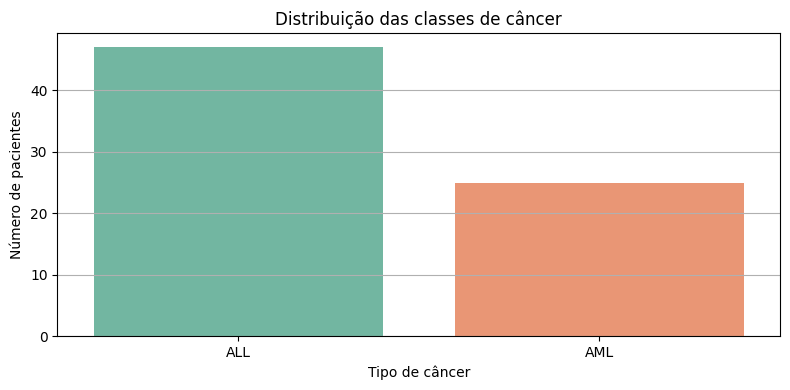

In [97]:
# plot distribution of classes

plt.figure(figsize=(8, 4))
sns.countplot(x='cancer', data=df_all, palette='Set2')
plt.title('Distribuição das classes de câncer')
plt.xlabel('Tipo de câncer')
plt.ylabel('Número de pacientes')
plt.xticks(ticks=[0, 1], labels=['ALL', 'AML'])
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("distribuicao_classes.png", dpi=150)

plt.show()  

In [98]:
# Check for missing values
missing_values = X.isnull().sum()
print("Missing values in each feature:\n", missing_values[missing_values > 0])
# Check for duplicate rows
duplicates = X.duplicated().sum()
print("Number of duplicate rows:", duplicates)

Missing values in each feature:
 Series([], dtype: int64)
Number of duplicate rows: 0


In [99]:
# ------------------------- Data Preparation -------------------------

# data normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------- Train/Test split -------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

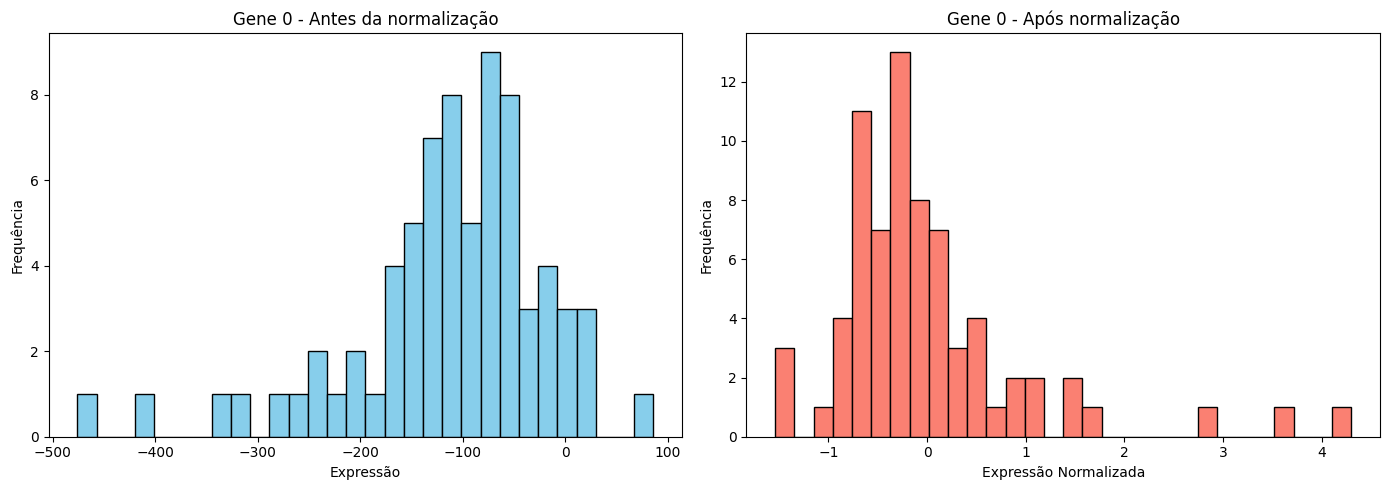

In [100]:
# Comparação visual dos dados antes e depois da normalização
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot dos dados originais (primeiro gene)
axs[0].hist(X.iloc[:, 0], bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Gene 0 - Antes da normalização')
axs[0].set_xlabel('Expressão')
axs[0].set_ylabel('Frequência')

# Plot dos dados normalizados (primeiro gene)
axs[1].hist(X_reduced[:, 0], bins=30, color='salmon', edgecolor='black')
axs[1].set_title('Gene 0 - Após normalização')
axs[1].set_xlabel('Expressão Normalizada')
axs[1].set_ylabel('Frequência')

plt.tight_layout()
plt.savefig("antesEdepois1.png", dpi=150)
plt.show()

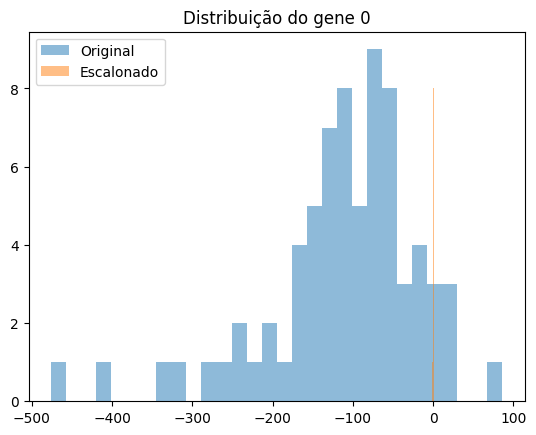

In [11]:
plt.hist(X.iloc[:, 0], bins=30, alpha=0.5, label='Original')
plt.hist(X_scaled[:, 0], bins=30, alpha=0.5, label='Escalonado')
plt.title('Distribuição do gene 0')
plt.legend()
plt.savefig("antesEdepois2.png", dpi=150)
plt.show()

___
### 1.3 Baseline "K‑NN completo"
Utilizando todas as 7129 features, com validação cruzada estratificada (k-fold = 5 e 10) e variando k em 1, 3, 5, 7 e 9. No final, é feita a amtriz de confusão média e registradas as métricas de precisão, recall e F1-Score.

In [101]:
results = {}

for k in [1, 3, 5, 7, 9]:
    for folds in [5, 10]:
        knn = KNeighborsClassifier(n_neighbors=k)
        cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
        scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
        res = cross_validate(knn, X_train, y_train, cv=cv, scoring=scoring)
        results[f"k={k},folds={folds}"] = res

# Consolidação das métricas
summary = []
for config, res in results.items():
    summary.append({
        "config": config,
        "K": int(config.split(',')[0].split('=')[1]),
        "folds": int(config.split(',')[1].split('=')[1]),
        "accuracy": np.mean(res['test_accuracy']),
        "precision": np.mean(res['test_precision_macro']),
        "recall": np.mean(res['test_recall_macro']),
        "f1": np.mean(res['test_f1_macro'])
    })

baseline_df = pd.DataFrame(summary)
print(baseline_df)

# Lista de colunas a validar
metricas = ["accuracy", "precision", "recall", "f1"]

# Dicionário para armazenar os resultados
maiores_resultados_StandardScaler = {}

# Loop para encontrar o maior valor e a linha correspondente para cada métrica
for metrica in metricas:
    maior_valor = baseline_df[metrica].max()
    maior_linha = baseline_df[baseline_df[metrica] == maior_valor]
    # Convertendo para dicionário a primeira linha (caso haja empate, pega só a primeira)
    maior_linha_dict = maior_linha.to_dict(orient='records')[0]
    maiores_resultados_StandardScaler[metrica] = {
        "valor": maior_valor,
        "linha": maior_linha_dict
    }

# Exibir os resultados
for metrica, resultado in maiores_resultados_StandardScaler.items():
    print(f"Métrica: {metrica}")
    print(f"Maior valor: {resultado['valor']}")
    print("Linha correspondente:")
    print(resultado['linha'])
    print("-" * 50)


C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

         config  K  folds  accuracy  precision    recall        f1
0   k=1,folds=5  1      5      0.56   0.578333  0.578571  0.546389
1  k=1,folds=10  1     10      0.50   0.500000  0.512500  0.466667
2   k=3,folds=5  3      5      0.74   0.733333  0.728571  0.715201
3  k=3,folds=10  3     10      0.74   0.682500  0.700000  0.659563
4   k=5,folds=5  5      5      0.78   0.786310  0.740476  0.746227
5  k=5,folds=10  5     10      0.72   0.674167  0.683333  0.637897
6   k=7,folds=5  7      5      0.80   0.789167  0.725000  0.715000
7  k=7,folds=10  7     10      0.80   0.720833  0.733333  0.706349
8   k=9,folds=5  9      5      0.76   0.671667  0.658333  0.624020
9  k=9,folds=10  9     10      0.78   0.680000  0.700000  0.661706
Métrica: accuracy
Maior valor: 0.8
Linha correspondente:
{'config': 'k=7,folds=5', 'K': 7, 'folds': 5, 'accuracy': 0.8, 'precision': 0.7891666666666666, 'recall': 0.725, 'f1': 0.7150000000000001}
--------------------------------------------------
Métrica: precisi

C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

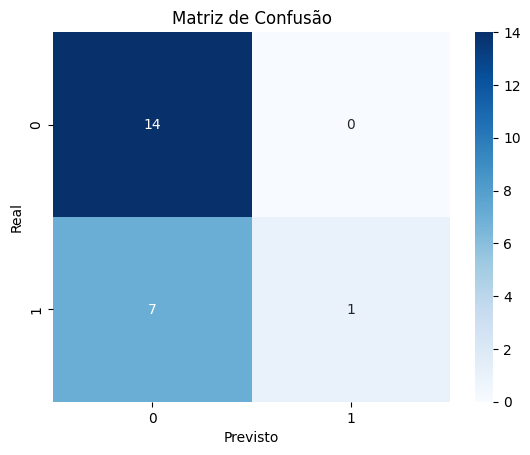

In [102]:
# ------------------- matriz de confusão -------------------
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

In [ ]:
# ------------------------- Data Preparation -------------------------
# data normalization
minmax_scaler = MinMaxScaler()
X_scaledM = minmax_scaler.fit_transform(X)

# ------------------- Train/Test split -------------------
X_train_Min, X_test_Min, y_train_Min, y_test_Min = train_test_split(
    X_scaledM, y, test_size=0.3, stratify=y, random_state=42)

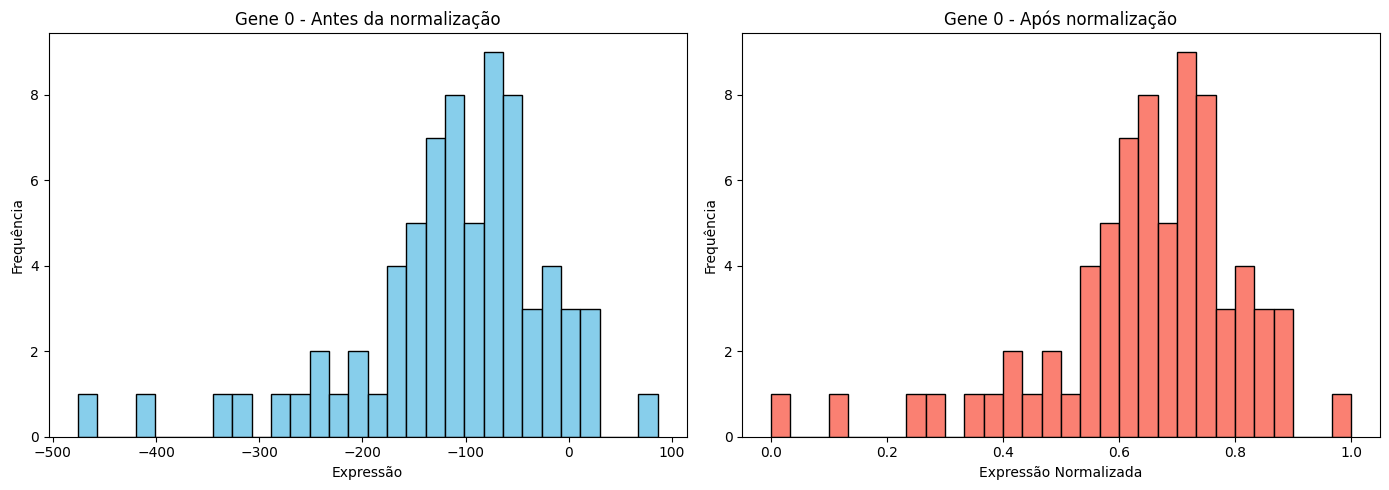

In [14]:
# Comparação visual dos dados antes e depois da normalização
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot dos dados originais (primeiro gene)
axs[0].hist(X.iloc[:, 0], bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Gene 0 - Antes da normalização')
axs[0].set_xlabel('Expressão')
axs[0].set_ylabel('Frequência')

# Plot dos dados normalizados (primeiro gene)
axs[1].hist(X_scaledM[:, 0], bins=30, color='salmon', edgecolor='black')
axs[1].set_title('Gene 0 - Após normalização')
axs[1].set_xlabel('Expressão Normalizada')
axs[1].set_ylabel('Frequência')

plt.tight_layout()
plt.savefig("antesEdepois1.png", dpi=150)
plt.show()

In [15]:
resultsMin = {}

for k in [1, 3, 5, 7, 9]:
    for folds in [5, 10]:
        knn = KNeighborsClassifier(n_neighbors=k)
        cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
        scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
        res = cross_validate(knn, X_train_Min, y_train_Min, cv=cv, scoring=scoring)
        resultsMin[f"k={k},folds={folds}"] = res
        
# Consolidação das métricas
summaryMin = []
for config, res in resultsMin.items():
    summaryMin.append({
        "config": config,
        "K": int(config.split(',')[0].split('=')[1]),
        "folds": int(config.split(',')[1].split('=')[1]),
        "accuracy": np.mean(res['test_accuracy']),
        "precision": np.mean(res['test_precision_macro']),
        "recall": np.mean(res['test_recall_macro']),
        "f1": np.mean(res['test_f1_macro'])
    })

baseline_df = pd.DataFrame(summaryMin)
print(baseline_df)

# Lista de colunas a validar
metricas = ["accuracy", "precision", "recall", "f1"]

# Dicionário para armazenar os resultados
maiores_resultados_MinMax = {}

# Loop para encontrar o maior valor e a linha correspondente para cada métrica
for metrica in metricas:
    maior_valor = baseline_df[metrica].max()
    maior_linha = baseline_df[baseline_df[metrica] == maior_valor]
    # Convertendo para dicionário a primeira linha (caso haja empate, pega só a primeira)
    maior_linha_dict = maior_linha.to_dict(orient='records')[0]
    maiores_resultados_MinMax[metrica] = {
        "valor": maior_valor,
        "linha": maior_linha_dict
    }

# Exibir os resultados
for metrica, resultado in maiores_resultados_MinMax.items():
    print(f"Métrica: {metrica}")
    print(f"Maior valor: {resultado['valor']}")
    print("Linha correspondente:")
    print(resultado['linha'])
    print("-" * 50)



C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

         config  K  folds  accuracy  precision    recall        f1
0   k=1,folds=5  1      5      0.58   0.591667  0.592857  0.563788
1  k=1,folds=10  1     10      0.54   0.516667  0.529167  0.504524
2   k=3,folds=5  3      5      0.72   0.725000  0.703571  0.682821
3  k=3,folds=10  3     10      0.74   0.682500  0.700000  0.659563
4   k=5,folds=5  5      5      0.76   0.706429  0.704762  0.689799
5  k=5,folds=10  5     10      0.76   0.728333  0.712500  0.679563
6   k=7,folds=5  7      5      0.80   0.789167  0.725000  0.715000
7  k=7,folds=10  7     10      0.80   0.720833  0.733333  0.706349
8   k=9,folds=5  9      5      0.80   0.886111  0.716667  0.724167
9  k=9,folds=10  9     10      0.82   0.750000  0.750000  0.724206
Métrica: accuracy
Maior valor: 0.8200000000000001
Linha correspondente:
{'config': 'k=9,folds=10', 'K': 9, 'folds': 10, 'accuracy': 0.8200000000000001, 'precision': 0.7499999999999999, 'recall': 0.75, 'f1': 0.7242063492063492}
------------------------------------

C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Beatriz\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [16]:
#pegar maior valor de maiores_resultados_MinMax e maiores_resultados_StandardScaler e salvar em um dicionário
maior_resultado = {}
for metrica in metricas:
    if maiores_resultados_MinMax[metrica]['valor'] > maiores_resultados_StandardScaler[metrica]['valor']:
        maior_resultado[metrica] = maiores_resultados_MinMax[metrica]
    else:
        maior_resultado[metrica] = maiores_resultados_StandardScaler[metrica]

# Exibir o maior resultado
print("Maior resultado entre MinMaxScaler e StandardScaler:")
for metrica, resultado in maior_resultado.items():
    print(f"Dataframe: {'MinMaxScaler' if resultado == maiores_resultados_MinMax[metrica] else 'StandardScaler'}")
    print(f"Métrica: {metrica}")
    print(f"Maior valor: {resultado['valor']}")
    print("Linha correspondente:")
    print(resultado['linha'])
    print("-" * 50)


Maior resultado entre MinMaxScaler e StandardScaler:
Dataframe: MinMaxScaler
Métrica: accuracy
Maior valor: 0.8200000000000001
Linha correspondente:
{'config': 'k=9,folds=10', 'K': 9, 'folds': 10, 'accuracy': 0.8200000000000001, 'precision': 0.7499999999999999, 'recall': 0.75, 'f1': 0.7242063492063492}
--------------------------------------------------
Dataframe: MinMaxScaler
Métrica: precision
Maior valor: 0.8861111111111111
Linha correspondente:
{'config': 'k=9,folds=5', 'K': 9, 'folds': 5, 'accuracy': 0.8, 'precision': 0.8861111111111111, 'recall': 0.7166666666666666, 'f1': 0.7241666666666667}
--------------------------------------------------
Dataframe: MinMaxScaler
Métrica: recall
Maior valor: 0.75
Linha correspondente:
{'config': 'k=9,folds=10', 'K': 9, 'folds': 10, 'accuracy': 0.8200000000000001, 'precision': 0.7499999999999999, 'recall': 0.75, 'f1': 0.7242063492063492}
--------------------------------------------------
Dataframe: StandardScaler
Métrica: f1
Maior valor: 0.746227

In [24]:
# ------------------- Model evaluation -------------------

#pega o maior valor entre todos e salva ele e o k e o folds
maior_valor = 0
for metrica in metricas:
    if maior_resultado[metrica]['valor'] > maior_valor:
        maior_valor = maior_resultado[metrica]['valor']
        k = maior_resultado[metrica]['linha']['K']
        folds = maior_resultado[metrica]['linha']['folds']
print(f"Maior valor: {maior_valor}, K: {k}, Folds: {folds}")

# best model
final_model = KNeighborsClassifier(n_neighbors=k)
cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
res = cross_validate(final_model, X_train_Min, y_train_Min, cv=cv, scoring='precision_macro')
print(f"Best model: K={k}, Folds={folds}, Precision={np.mean(res['test_score']):.4f}")

final_model.fit(X_train_Min, y_train_Min)  # training the model

y_pred = final_model.predict(X_test_Min)
acc = accuracy_score(y_test_Min, y_pred)
precision = precision_score(y_test_Min, y_pred, average='macro')
recall = recall_score(y_test_Min, y_pred, average='macro')
f1 = f1_score(y_test_Min, y_pred, average='macro')
print(f"Acurácia: {acc:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Maior valor: 0.8861111111111111, K: 9, Folds: 5
Best model: K=9, Folds=5, Precision=0.8861
Acurácia: 0.6818
Precisão: 0.8333
Recall: 0.5625
F1 Score: 0.5111


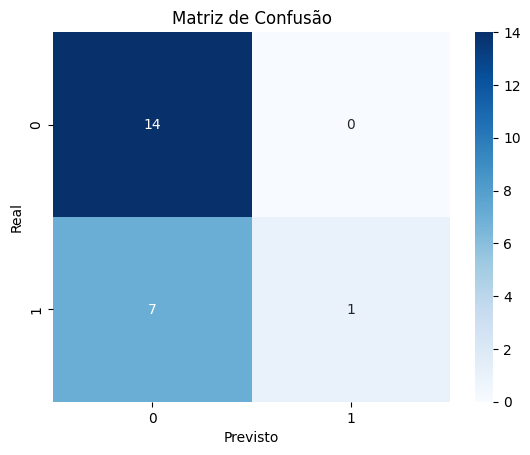

In [ ]:
# ------------------- Matriz de Confusão -------------------
cm = confusion_matrix(y_test_Min, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

___
### 1.4 Seleção de características (pelo menos duas abordagens distintas)
Abordagens utilizdas: Seleção Univariada (ANOVA F-Score) e Importância via Random Forest

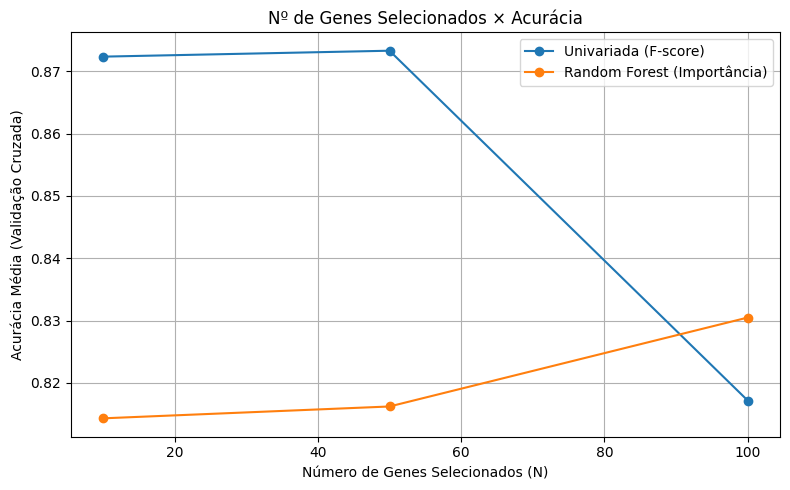

In [103]:
# Parâmetros
from sklearn.ensemble import RandomForestClassifier

minmax_scaler = MinMaxScaler()
X_scaledM = minmax_scaler.fit_transform(X)

X_reducedM = pd.DataFrame(minmax_scaler.fit_transform(X), columns=X.columns)


N_features = [10, 50, 100]  # caso tenha menos que 100 features
results = {
    'Univariada (F-score)': [],
    'Random Forest (Importância)': []
}

# Método 1: Seleção Univariada (ANOVA F-score)
for N in N_features:
    selector = SelectKBest(score_func=f_classif, k=N)
    X_selected = selector.fit_transform(X_reducedM, y)
    model = KNeighborsClassifier(n_neighbors=5)
    scores = cross_val_score(model, X_selected, y, cv=5)
    results['Univariada (F-score)'].append(scores.mean())

# Método 2: Importância via Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_reducedM, y)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # do maior pro menor

for N in N_features:
    top_indices = indices[:N]
    X_selected = X_reducedM.iloc[:, top_indices]
    model = KNeighborsClassifier(n_neighbors=5)
    scores = cross_val_score(model, X_selected, y, cv=5)
    results['Random Forest (Importância)'].append(scores.mean())

# Gráfico: N × Acurácia
plt.figure(figsize=(8, 5))
for method, accs in results.items():
    plt.plot(N_features, accs, marker='o', label=method)

plt.title("Nº de Genes Selecionados × Acurácia")
plt.xlabel("Número de Genes Selecionados (N)")
plt.ylabel("Acurácia Média (Validação Cruzada)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

___
### 1.5 Comparação crítica
Comparando o desempenho dos modelos: (i) todas as features; (ii) cada subconjunto selecionado. Discussão do over/underfitting, efeito da alta dimensionalidade e tempo de execução estarão no relatório.

In [105]:
# Extrai o melhor resultado do baseline
melhor_baseline = baseline_df.loc[baseline_df['accuracy'].idxmax()].copy()
melhor_baseline['método'] = 'Todas as features'
melhor_baseline['N'] = X.shape[1]  # total de genes

# Organiza resultados da seleção de features em DataFrame
comparativos = []

for metodo, accs in results.items():
    for i, N in enumerate(N_features):
        comparativos.append({
            'método': metodo,
            'N': N,
            'accuracy': accs[i],
            'precision': None,
            'recall': None,
            'f1': None
        })

fs_df = pd.DataFrame(comparativos)

# Junta o baseline com os modelos com seleção de features
comparacao_df = pd.concat([
    fs_df,
    pd.DataFrame([melhor_baseline])[['método', 'N', 'accuracy', 'precision', 'recall', 'f1']]
], ignore_index=True)

# Exibe a tabela ordenada por acurácia
print(comparacao_df.sort_values(by='accuracy', ascending=False))

"""
# Gráfico de comparação de acurácia


plt.figure(figsize=(10,6))
sns.lineplot(data=comparacao_df, x='N', y='accuracy', hue='método', marker='o')
plt.title("Comparação de Acurácia: Todas as Features vs Seleção de Features")
plt.xlabel("Número de Genes Selecionados")
plt.ylabel("Acurácia")
plt.grid(True)
plt.tight_layout()
plt.show()

"""



                        método     N  accuracy  precision  recall     f1
1         Univariada (F-score)    50  0.873333        NaN     NaN    NaN
0         Univariada (F-score)    10  0.872381        NaN     NaN    NaN
5  Random Forest (Importância)   100  0.830476        NaN     NaN    NaN
2         Univariada (F-score)   100  0.817143        NaN     NaN    NaN
4  Random Forest (Importância)    50  0.816190        NaN     NaN    NaN
3  Random Forest (Importância)    10  0.814286        NaN     NaN    NaN
6            Todas as features  7129  0.800000   0.789167   0.725  0.715


C:\Users\Beatriz\AppData\Local\Temp\ipykernel_18568\978557926.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comparacao_df = pd.concat([


'\n# Gráfico de comparação de acurácia\n\n\nplt.figure(figsize=(10,6))\nsns.lineplot(data=comparacao_df, x=\'N\', y=\'accuracy\', hue=\'método\', marker=\'o\')\nplt.title("Comparação de Acurácia: Todas as Features vs Seleção de Features")\nplt.xlabel("Número de Genes Selecionados")\nplt.ylabel("Acurácia")\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n\n'

___
### 1.6 Interpretação biológica
Extra: balanceamento de classes feito com SMOTE, pois o dataset apresenta um desbalanceamento considerável (ALL ≈ 65%, AML ≈ 35%). Por isso, ele identifica muito bem o ALL, mas ainda falha em identificar a classe minoritária. Há um overfitting da classe no espaço reduzido + comparação de matrizes de confusão.

         config  K  folds  accuracy  precision    recall        f1
0   k=1,folds=5  1      5  0.879121   0.890476  0.878571  0.878009
1  k=1,folds=10  1     10  0.909524   0.930000  0.908333  0.906032
2   k=3,folds=5  3      5  0.880220   0.888095  0.878571  0.879071
3  k=3,folds=10  3     10  0.878571   0.892500  0.875000  0.874960
4   k=5,folds=5  5      5  0.909890   0.921825  0.907143  0.908366
5  k=5,folds=10  5     10  0.878571   0.892500  0.875000  0.874960
6   k=7,folds=5  7      5  0.925275   0.934325  0.923810  0.924123
7  k=7,folds=10  7     10  0.923810   0.934167  0.920833  0.921270
8   k=9,folds=5  9      5  0.925275   0.934325  0.923810  0.924123
9  k=9,folds=10  9     10  0.909524   0.924167  0.904167  0.905714
Métrica: accuracy
Maior valor: 0.9252747252747252
Linha correspondente:
{'config': 'k=7,folds=5', 'K': 7, 'folds': 5, 'accuracy': 0.9252747252747252, 'precision': 0.9343253968253968, 'recall': 0.9238095238095237, 'f1': 0.9241233766233765}
------------------------

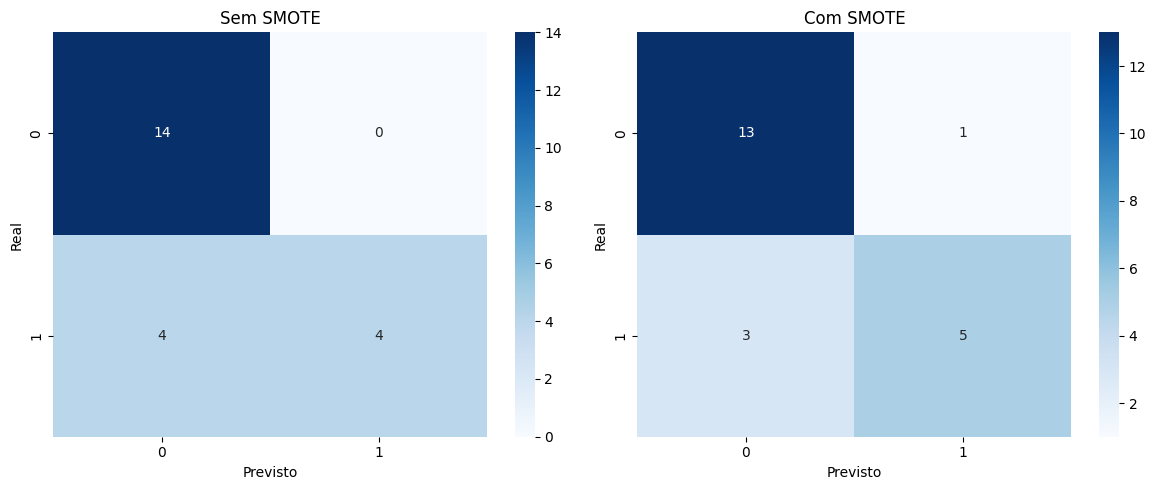

In [88]:
# ------------------- SMOTE e KNN -------------------
# data normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Redução para 100 features (pode ser com SelectKBest ou outro método)
selector = SelectKBest(score_func=f_classif, k=20)
X_reduced = selector.fit_transform(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.3, stratify=y, random_state=42)

# SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

results = {}

for k in [1, 3, 5, 7, 9]:
    for folds in [5, 10]:
        knn = KNeighborsClassifier(n_neighbors=k)
        cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
        scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
        res = cross_validate(knn, X_resampled, y_resampled, cv=cv, scoring=scoring)
        results[f"k={k},folds={folds}"] = res

# Consolidação das métricas
summary = []
for config, res in results.items():
    summary.append({
        "config": config,
        "K": int(config.split(',')[0].split('=')[1]),
        "folds": int(config.split(',')[1].split('=')[1]),
        "accuracy": np.mean(res['test_accuracy']),
        "precision": np.mean(res['test_precision_macro']),
        "recall": np.mean(res['test_recall_macro']),
        "f1": np.mean(res['test_f1_macro'])
    })

baseline_df = pd.DataFrame(summary)
print(baseline_df)

# Lista de colunas a validar
metricas = ["accuracy", "precision", "recall", "f1"]

# Dicionário para armazenar os resultados
maiores_resultados_StandardScaler = {}

# Loop para encontrar o maior valor e a linha correspondente para cada métrica
for metrica in metricas:
    maior_valor = baseline_df[metrica].max()
    maior_linha = baseline_df[baseline_df[metrica] == maior_valor]
    # Convertendo para dicionário a primeira linha (caso haja empate, pega só a primeira)
    maior_linha_dict = maior_linha.to_dict(orient='records')[0]
    maiores_resultados_StandardScaler[metrica] = {
        "valor": maior_valor,
        "linha": maior_linha_dict
    }

# Exibir os resultados
for metrica, resultado in maiores_resultados_StandardScaler.items():
    print(f"Métrica: {metrica}")
    print(f"Maior valor: {resultado['valor']}")
    print("Linha correspondente:")
    print(resultado['linha'])
    print("-" * 50)

# ------------------- matriz de confusão -------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Sem SMOTE
knn_original = KNeighborsClassifier(n_neighbors=5)
knn_original.fit(X_train, y_train)
y_pred_original = knn_original.predict(X_test)
cm_original = confusion_matrix(y_test, y_pred_original)
sns.heatmap(cm_original, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Sem SMOTE")
axes[0].set_xlabel("Previsto")
axes[0].set_ylabel("Real")

# Com SMOTE
knn_smote = KNeighborsClassifier(n_neighbors=5)
knn_smote.fit(X_resampled, y_resampled)
y_pred_smote = knn_smote.predict(X_test)
cm_smote = confusion_matrix(y_test, y_pred_smote)
sns.heatmap(cm_smote, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title("Com SMOTE")
axes[1].set_xlabel("Previsto")
axes[1].set_ylabel("Real")

plt.tight_layout()
plt.show()

Selecionando os 5 genes que mais contribuíram para o melhor modelo

In [89]:
# ------------------- Most Relevant Genes -------------------
# get the selected features from the SelectKBest
selected_indices = selector.get_support(indices=True)
selected_scores = selector.scores_[selected_indices]

selected_genes = X.columns[selected_indices]
gene_scores = list(zip(selected_genes, selected_scores))

gene_scores_sorted = sorted(gene_scores, key=lambda x: x[1], reverse=True)

# ranked by F-score
print("Genes mais relevantes (top 5):")
for gene, score in gene_scores_sorted[:5]:
    print(f"{gene}: F-score = {score:.2f}")

Genes mais relevantes (top 5):
M80254_at: F-score = 34.52
M96326_rna1_at: F-score = 33.38
X17042_at: F-score = 30.00
U46751_at: F-score = 29.70
X16546_at: F-score = 26.86
